In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product k.csv', parse_dates=['Month-Year'])

In [3]:
sales_k= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_k.shape

(60, 2)

In [5]:
sales_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_k['Sales'].sum()

32299304

In [7]:
sales_k = sales_k.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_k.head()

ds       y
0 2019-01-01  505010
1 2019-02-01  521132
2 2019-03-01  580897
3 2019-04-01  612559
4 2019-05-01  550697

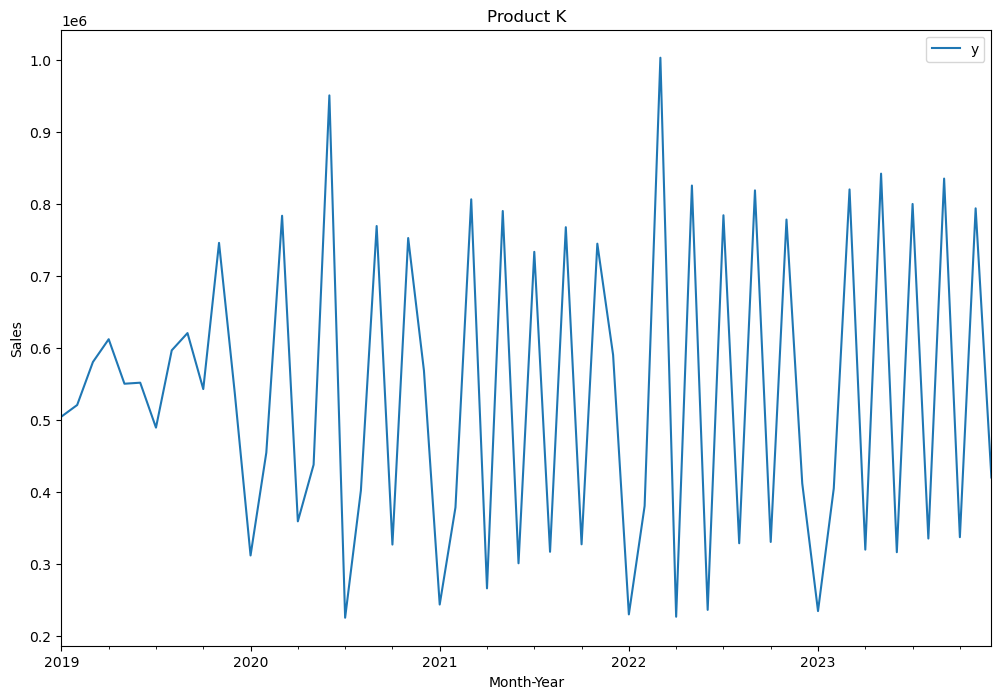

In [8]:
ax = sales_k.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product K')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_k['y'])

ADF Statistics: -4.339743021722731
p- value: 0.0003788479952270515
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [12]:
train= sales_k[:48]
test=sales_k[48:]

# Hyperparameter Tuning

In [31]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:56:12 - cmdstanpy - INFO - Chain [1] start processing
16:56:12 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:36 - cmdstanpy - INFO - Chain [1] start processing
16:56:37 - cmdstanpy - INFO - Chain [1] done processing
16:56:40 - cmdstanpy - INFO - Chain [1] start processing
16:56:40 - cmdstanpy - INFO - Chain [1] done processing
16:56:43 - cmdstanpy - INFO - Chain [1] start processing
16:56:43 - cmdstanpy - INFO - Chain [1] done processing
16:56:46 - cmdstanpy - INFO - Chain [1] start processing
16:56:46 - cmdstanpy - INFO - Chain [1] done processing
16:56:49 - cmdstanpy - INFO - Chain [1] start processing
16:56:50 - cmdstanpy - INFO - Chain [1] done processing
16:56:57 - cmdstanpy - INFO - Chain [1] start processing
16:56:57 - cmdstanpy - INFO - Chain [1] done processing
16:57:00 - cmdstanpy - INFO - Chain [1] start processing
16:57:00 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   277605.572315  
1   281904.576051  
2   202357.689603  
3   205166.973553  
4   199014.940919  
.. 

In [32]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
64                    0.500                     1.00         additive   
4                     0.001                     1.00         additive   
68                    0.500                     5.00         additive   
70                    0.500                    10.00         additive   
66                    0.500                     3.00         additive   
..                      ...                      ...              ...   
37                    0.200                     0.01   multiplicative   
49                    0.300                     0.01   multiplicative   
61                    0.500                     0.01   multiplicative   
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   

             rmse  
64  198279.397538  
4   199014.940919  
68  199861.444525  
70  200083.261395  
66  200099.711151  
..            ...  
37  272118.763461  
49  272123.453174  
61  272123.563496  
0   277605.572315  
1   281904.576051  

[72 rows x 4 columns]

In [33]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


In [49]:
# Create a Prophet model
model = Prophet( changepoint_prior_scale= 0.5,seasonality_prior_scale=1.0, seasonality_mode = 'additive',
                interval_width=0.95)

In [50]:
model.fit(train)

17:01:43 - cmdstanpy - INFO - Chain [1] start processing
17:01:44 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [52]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [53]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [54]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
48 2023-01-01  311960.795692   51391.252888  557136.897405
49 2023-02-01  423394.996459  161719.251411  688162.937821
50 2023-03-01  717606.080746  458751.623260  968295.609438
51 2023-04-01  414386.336427  169751.493897  669094.948427
52 2023-05-01  662236.160825  425901.939107  891492.976340
53 2023-06-01  349001.422345  120011.522445  582950.499383
54 2023-07-01  624352.095427  370180.432403  879702.442002
55 2023-08-01  446091.484558  185855.087500  698158.866017
56 2023-09-01  671522.387630  435913.775244  922528.290876
57 2023-10-01  420201.253593  177313.726195  672615.979318
58 2023-11-01  726878.322081  492420.388607  999101.607805
59 2023-12-01  468915.347980  216608.847385  714206.756830

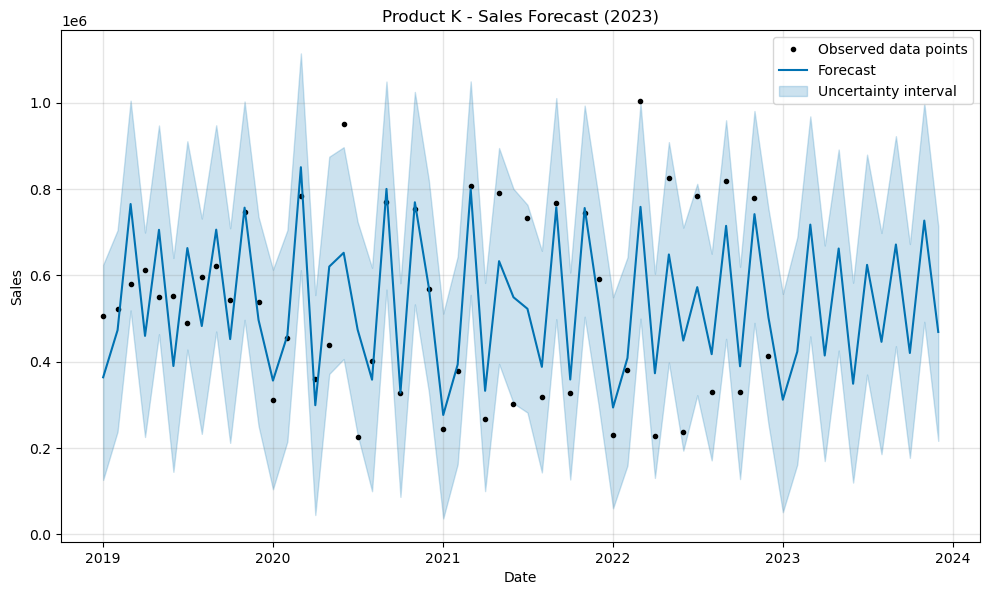

In [55]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product K - Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

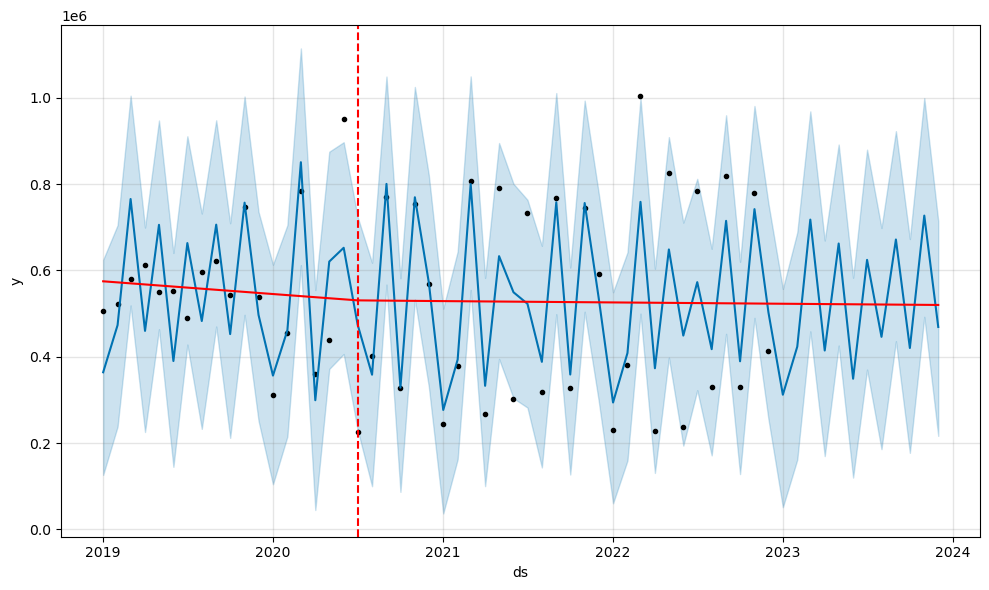

In [56]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

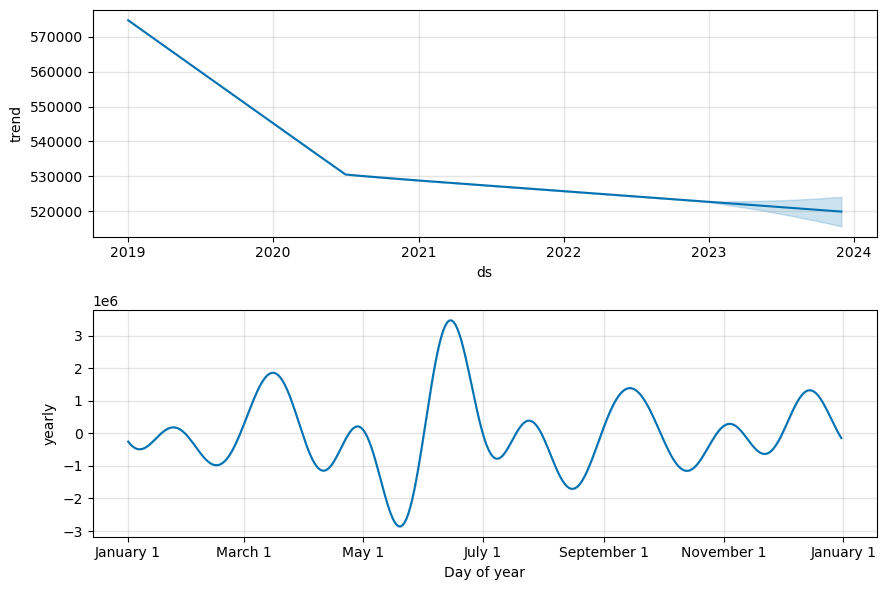

In [57]:
fig2 = model.plot_components(forecast)

In [58]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
48 2023-01-01  311960.795692   51391.252888  557136.897405
49 2023-02-01  423394.996459  161719.251411  688162.937821
50 2023-03-01  717606.080746  458751.623260  968295.609438
51 2023-04-01  414386.336427  169751.493897  669094.948427
52 2023-05-01  662236.160825  425901.939107  891492.976340
53 2023-06-01  349001.422345  120011.522445  582950.499383
54 2023-07-01  624352.095427  370180.432403  879702.442002
55 2023-08-01  446091.484558  185855.087500  698158.866017
56 2023-09-01  671522.387630  435913.775244  922528.290876
57 2023-10-01  420201.253593  177313.726195  672615.979318
58 2023-11-01  726878.322081  492420.388607  999101.607805
59 2023-12-01  468915.347980  216608.847385  714206.756830

In [59]:
sales_k.tail(12) 

ds       y
48 2023-01-01  234804
49 2023-02-01  405296
50 2023-03-01  820679
51 2023-04-01  320174
52 2023-05-01  842609
53 2023-06-01  316593
54 2023-07-01  800485
55 2023-08-01  335618
56 2023-09-01  835745
57 2023-10-01  337462
58 2023-11-01  794412
59 2023-12-01  420417

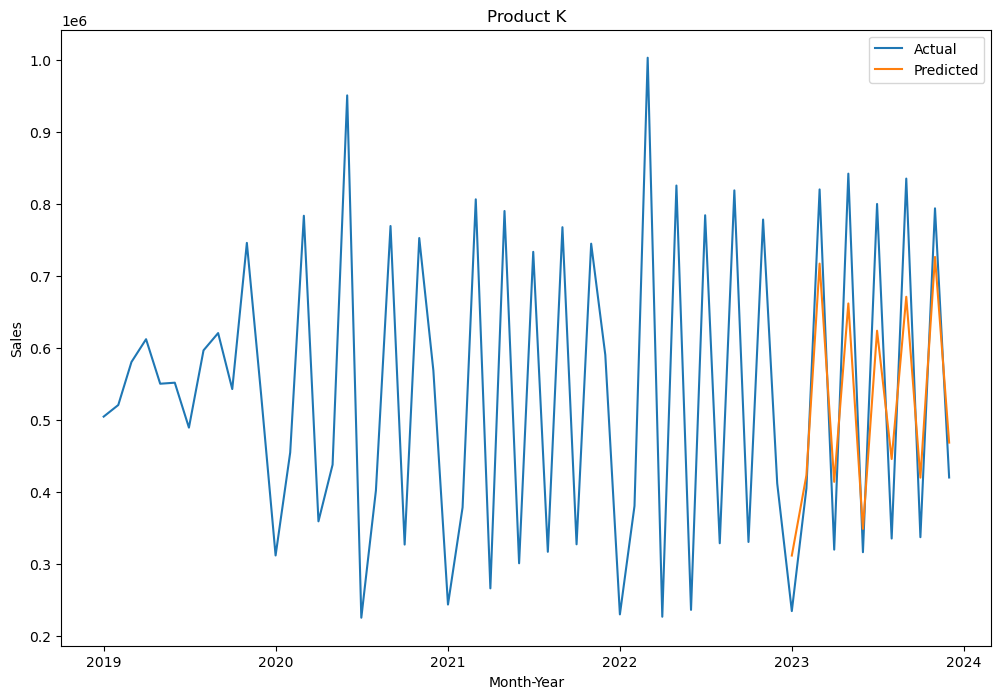

In [60]:
# Reset index of sales_b DataFrame
sales_k_reset_index = sales_k.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_k_reset_index['ds'], sales_k_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product K')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [61]:
#model evaluation

In [62]:
pred=forecasted_df['yhat']
test_df=test['y']

In [63]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 96243.549
MAPE - FB PROPHET: 0.192
MSE - FB PROPHET: 11943360961.366
RMSE - FB PROPHET: 109285.685


In [64]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

# Cross Validation

In [65]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [66]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse           rmse            mae      mape     mdape  \
0   31 days  5.739731e+09   75761.014557   75761.014557  0.329110  0.329110   
1   62 days  5.808420e+08   24100.663443   24100.663443  0.063279  0.063279   
2   90 days  1.232895e+11  351126.116823  351126.116823  0.349839  0.349839   
3  121 days  4.041998e+10  201047.205064  201047.205064  0.885909  0.885909   
4  151 days  6.477655e+10  254512.385599  254512.385599  0.308094  0.308094   
5  182 days  8.317632e+10  288403.043396  288403.043396  1.219602  1.219602   
6  212 days  9.178720e+10  302964.024979  302964.024979  0.386045  0.386045   
7  243 days  1.378068e+10  117391.139109  117391.139109  0.356772  0.356772   
8  274 days  2.434926e+10  156042.501346  156042.501346  0.190445  0.190445   
9  304 days  5.774632e+09   75990.999965   75990.999965  0.229688  0.229688   
10 335 days  3.482289e+09   59010.925258   59010.925258  0.075768  0.075768   
11 365 days  1.461960e+10  120911.531844  120911.531844  0.293351  0.293351   

       smape  coverage  
0   0.282605       1.0  
1   0.061338       1.0  
2   0.424006       0.0  
3   0.613955       0.0  
4   0.364197       0.0  
5   0.757611       0.0  
6   0.478384       0.0  
7   0.302763       1.0  
8   0.210488       1.0  
9   0.206027       1.0  
10  0.078752       1.0  
11  0.255827       1.0

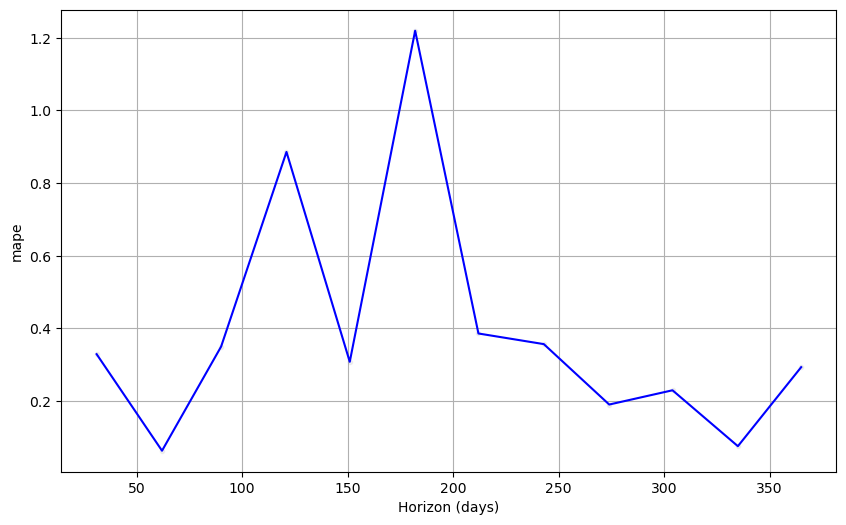

In [67]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

# FORECASTING

In [35]:
model_forecast = Prophet( changepoint_prior_scale= 0.500,seasonality_prior_scale=1.00, seasonality_mode = 'additive',
                interval_width=0.95)

In [36]:
model_forecast.fit(sales_k)

13:25:43 - cmdstanpy - INFO - Chain [1] start processing
13:25:43 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=12, freq='MS')  # 12 months in 2024

In [38]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [39]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [40]:
forecasted_f_df

ds           yhat     yhat_lower    yhat_upper
60 2024-01-01  327235.197105   89256.008317  5.522263e+05
61 2024-02-01  448055.240686  239614.372486  6.719174e+05
62 2024-03-01  846465.783800  626847.315088  1.081314e+06
63 2024-04-01  308277.706777   70140.206814  5.287813e+05
64 2024-05-01  621737.932798  373585.639859  8.531055e+05
65 2024-06-01  673820.359826  435777.959547  9.068903e+05
66 2024-07-01  478059.363385  243589.896558  7.075058e+05
67 2024-08-01  374089.666376  153694.153104  6.208795e+05
68 2024-09-01  802316.675134  548707.368777  1.043672e+06
69 2024-10-01  335785.608479   91156.267903  5.597585e+05
70 2024-11-01  767955.532074  510669.067562  9.888607e+05
71 2024-12-01  575942.919744  348684.338479  7.842219e+05

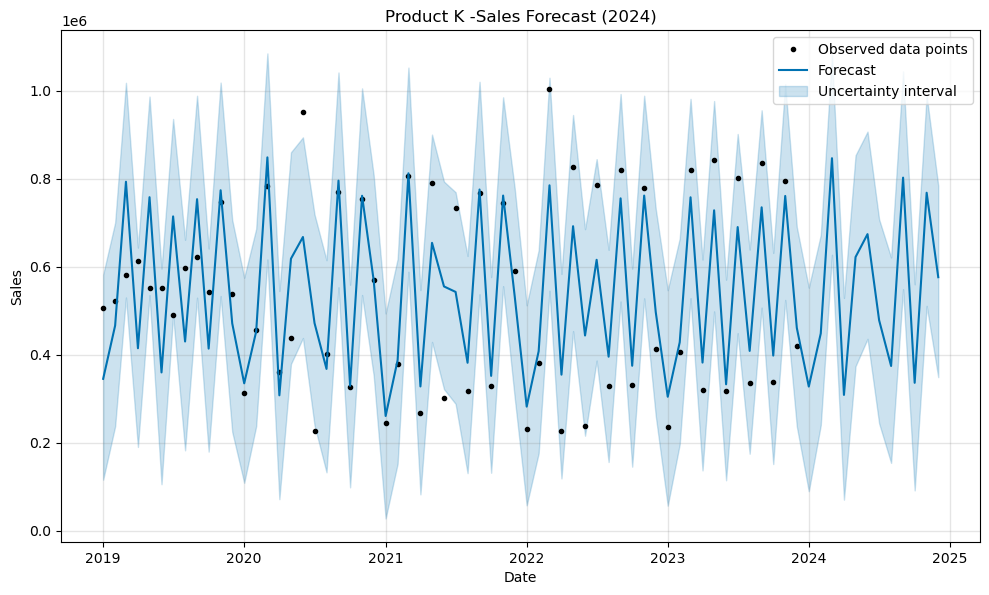

In [41]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product K -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [42]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [43]:
plot_components_plotly(model_forecast, forecast_f)